# Roteiro
1. Leitura dos dados
2. Criação dos datasets e dataloaders
3. Definição do modelo, otimizador e loss function
4. Definição das funções de treino, validação e teste
5. Treinamento
6. Inferência

# 1. Leitura dos dados
Carregar dataset

In [14]:
import splitfolders
splitfolders.ratio('memoria_esquerda', output="memoria_esquerda_splitted", seed=1337, ratio=(0.6, 0.2, 0.2)) 

Copying files: 24 files [00:00, 298.36 files/s]


# 2. Criação dos datasets e dataloaders

In [4]:
# imports
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

Criando as transformações nos dados
- resize
- normalização

O dataset de treino sofre resize e normalização de acordo com o ImageNet Dataset

In [5]:
train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Criação dos datasets e dataloarders de treino, teste e validação

In [19]:
data_dir = 'memoria_esquerda_splitted'

train_dataset = datasets.ImageFolder(os.path.join(data_dir + "/train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir + "/val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir + "/test"), transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f'Quantidade de classes: {num_classes}')
print(f'Nome das classes: \n{class_names}')

Quantidade de classes: 2
Nome das classes: 
['esquerda_bom', 'esquerda_ruim']


# 3. Definição do modelo, otimizador e loss function

In [20]:
from torchvision import models
import torch.nn as nn
from torch import optim

device = torch.device('cpu')

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
print(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Definição das funções de treino, validação e teste

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import numpy as np


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            output_prob = model(inputs)
            _, predicted_labels = torch.max(output_prob, 1)

            n += labels.size(0) # add batch_size num of samples being iterated
            correct_pred += (predicted_labels == labels).sum() # sum array of bools (1's are correct predictions)

    return correct_pred.float() / n

def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        running_loss += loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def val(val_loader, model, criterion, device):
  
    model.eval()
    running_loss = 0
    
    for inputs, labels in val_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and record loss
        with torch.no_grad():
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, test_dataloader, epoches, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_acc = 0.0
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model and validate
    for epoch in range(epoches):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = val(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # accuracies
        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            test_acc = get_accuracy(model, test_dataloader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                    f'Epoch: {epoch}/t'
                    f'Train loss: {train_loss:.4f}\t'
                    f'Valid loss: {valid_loss:.4f}\t'
                    f'Train accuracy: {100 * train_acc:.2f}\t'
                    f'Val accuracy: {100 * valid_acc:.2f}\t'
                    f'Test accuracy: {100 * test_acc:.2f}')

        # create a copy of our model when it test its best
        if test_acc >= best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    plot_losses(train_losses, valid_losses)
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

# 5. Treinamento

19:59:36 --- Epoch: 0	Train loss: 0.3570	Valid loss: 0.0449	Train accuracy: 94.44	Val accuracy: 100.00	Test accuracy: 100.00
19:59:39 --- Epoch: 1	Train loss: 0.6246	Valid loss: 0.3461	Train accuracy: 88.89	Val accuracy: 75.00	Test accuracy: 100.00
19:59:43 --- Epoch: 2	Train loss: 1.6227	Valid loss: 4.2403	Train accuracy: 55.56	Val accuracy: 25.00	Test accuracy: 50.00
19:59:47 --- Epoch: 3	Train loss: 0.9698	Valid loss: 1.5037	Train accuracy: 77.78	Val accuracy: 50.00	Test accuracy: 83.33
19:59:51 --- Epoch: 4	Train loss: 0.4747	Valid loss: 0.1092	Train accuracy: 94.44	Val accuracy: 100.00	Test accuracy: 83.33
19:59:54 --- Epoch: 5	Train loss: 0.2678	Valid loss: 0.0135	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
19:59:58 --- Epoch: 6	Train loss: 0.2454	Valid loss: 0.0306	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
20:00:02 --- Epoch: 7	Train loss: 0.3187	Valid loss: 0.0258	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
20:

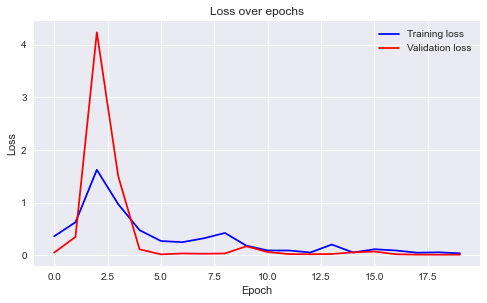

In [22]:
model = training_loop(model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=train_dataloader, 
    valid_loader=val_dataloader, 
    test_dataloader=test_dataloader,
    epoches=20, 
    device=device, 
    print_every=1
)

torch.save(model.state_dict(), "memoria_esquerda_classificacao.pth")

tensor([481])


IndexError: list index out of range

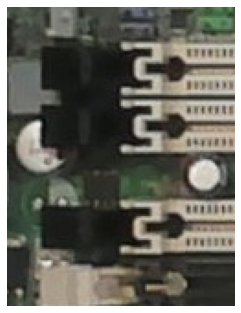

In [72]:
from PIL import Image

# Carregando o modelo
device = torch.device('cpu')
model = models.resnet18(pretrained=True)

model.load_state_dict(torch.load("memoria_esquerda_classificacao.pth"),  strict=False)
model.classifier = nn.Linear(in_features=512, out_features=num_classes, bias=True)
model.eval()
model.to(device)

# Mantemos o transform utilizado para validação
transform = transforms.Compose([
        transforms.Resize((224,350)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = Image.open("C:/Users/erh/eduardo/Desktop_4/INE_visao_computacional/memoria_esquerda_splitted/val/esquerda_bom/11.png")
plt.imshow(np.array(image))
plt.grid(False)
plt.axis(False)
image = transform(image)
image = image[None,...]
image = image.float()#.cpu()#.cuda()#to(device)
with torch.no_grad():
    output = model(image)
_, predicted = torch.max(output, 1)
print(predicted)
answer = class_names[predicted]
plt.title(f"predicted: {answer}")
plt.show()

In [69]:
model.load_state_dict(torch.load("memoria_esquerda_classificacao.pth"),  strict=False)
#print(model)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
filename = "C:/Users/erh/eduardo/Desktop_4/INE_visao_computacional/memoria_esquerda_splitted/val/esquerda_bom/11.png"
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize((224, 350)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cpu')
    model.to('cpu')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0].shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

torch.Size([1000])
tensor([2.6846e-04, 1.1063e-02, 6.1195e-05, 4.7615e-04, 7.9974e-05, 1.5731e-03,
        5.6262e-04, 6.6308e-04, 3.7054e-04, 2.1091e-04, 1.6147e-04, 1.0947e-03,
        2.2988e-03, 2.6455e-03, 7.8388e-04, 3.8168e-04, 3.3437e-04, 9.1766e-04,
        5.5351e-04, 6.9683e-04, 3.7243e-03, 1.4782e-03, 2.5491e-03, 9.9735e-05,
        2.0817e-03, 2.1196e-04, 1.2760e-04, 3.9021e-04, 6.0979e-04, 3.6514e-04,
        2.2212e-03, 5.8546e-04, 4.6462e-04, 1.8478e-03, 3.1952e-04, 1.0868e-03,
        1.1396e-04, 8.0863e-04, 8.0017e-05, 1.4506e-04, 5.3321e-04, 1.0555e-04,
        2.6943e-04, 5.9098e-04, 6.2193e-05, 5.6254e-04, 1.6591e-03, 1.2659e-03,
        1.8330e-03, 2.1755e-04, 1.3548e-03, 8.8849e-04, 5.2365e-04, 4.2602e-04,
        2.6159e-04, 1.9156e-04, 6.2228e-04, 4.1210e-04, 7.5864e-04, 6.5528e-04,
        6.8252e-04, 8.2754e-04, 5.3416e-05, 1.6234e-03, 3.5285e-04, 6.5711e-05,
        8.3751e-05, 1.7711e-04, 4.6723e-04, 6.9399e-04, 6.7562e-04, 1.5163e-04,
        1.5614e-04, 4